# BIGRoC: Boosting Image Generation via a Robust Classifier
--------
## Conditional Boosting - CIFAR-10
This colab notebook contains the needed code to experiment with our proposed algorithm for boosting the results of conditional image generators using CIFAR-10 dataset. In addition, this notebook enables to visualize the qualitative improvement attained by BIGRoC.

**How to use**

1.   Upload the notebook to colab
2.   Make sure that colab uses a GPU (Edit $\rightarrow$ Notebook settings $\rightarrow$ Hardware accelerator)



*Downloading pretrained generators:*

The pretrained image generators are stored in a [Google Drive](https://drive.google.com/drive/folders/1yN6WjMmc-pi3zHylF-I1jri7I2nZpsGJ?usp=sharing). This notebook mounts google drive and assumes that [this directory](https://drive.google.com/drive/folders/1yN6WjMmc-pi3zHylF-I1jri7I2nZpsGJ?usp=sharing) is located in your root folder in Google Drive. Therefore, please open the Google Drive's link and choose "add a shortcut to drive" and pick "My Drive" is the chosen location. By doing so, you are ready to go :)

If you rather not to mount your google drive, download the files and edit the relevant checkpoint paths accordingly.

**credits**

This notebook uses the following packages:

*   [mimicry github](https://github.com/kwotsin/mimicry) as a reliable source for pretrained image generators.
*   [robustness package](https://robustness.readthedocs.io/en/latest/) for a pretrained robust classifier.




In [ ]:
!pip install torch==1.8.2+cu102 torchvision==0.9.2+cu102 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html

In [ ]:
# install mimicry
!pip install git+https://github.com/kwotsin/mimicry.git

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import torch
import torchvision

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


testset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=50000,
                                          shuffle=True, num_workers=2)

X_test, Y_test = next(iter(testloader))
X_test = X_test.cuda()
Y_test = Y_test.cuda()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


# Adversarial Image Boosting

In [ ]:
!pip install robustness

     |████████████████████████████████| 95 kB 3.9 MB/s 
     |████████████████████████████████| 55 kB 4.5 MB/s 
     |████████████████████████████████| 124 kB 75.4 MB/s 
     |████████████████████████████████| 180 kB 74.5 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=0016ad40c4ca71195490d3e38ca5ffba8329872a1bc41a966c4105efefaab906
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil


In [ ]:
!wget http://andrewilyas.com/CIFAR.pt

--2022-01-21 10:29:13--  http://andrewilyas.com/CIFAR.pt
Resolving andrewilyas.com (andrewilyas.com)... 52.218.224.234
Connecting to andrewilyas.com (andrewilyas.com)|52.218.224.234|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 188522353 (180M) [binary/octet-stream]
Saving to: ‘CIFAR.pt’

CIFAR.pt            100%[===================>] 179.79M  16.3MB/s    in 9.9s    

2022-01-21 10:29:23 (18.1 MB/s) - ‘CIFAR.pt’ saved [188522353/188522353]



In [ ]:
from robustness import model_utils, datasets
import torch


def create_dl_model(DATA='CIFAR', BATCH_SIZE=128, NUM_WORKERS=8):
    '''
    :param DATA: Choices: ['CIFAR', 'ImageNet', 'RestrictedImageNet']
    :param bs: batch size
    :param num_workers:
    :return: a dataloader object
    '''

    # Load dataset
    dataset_function = getattr(datasets, DATA)
    dataset = dataset_function('data')
    train_loader, test_loader = dataset.make_loaders(workers=NUM_WORKERS,
                                          batch_size=BATCH_SIZE,
                                          data_aug=False)
    # Load model
    model_kwargs = {
        'arch': 'resnet50',
        'dataset': dataset,
        'resume_path': f'./{DATA}.pt'
    }
    model, _ = model_utils.make_and_restore_model(**model_kwargs)
    classifier = model.model
    classifier.eval()

    return train_loader, test_loader, classifier

_, _, model = create_dl_model(BATCH_SIZE=10000)

==> Preparing dataset cifar..
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


=> loading checkpoint './CIFAR.pt'
=> loaded checkpoint './CIFAR.pt' (epoch 153)


In [ ]:
import torch
from torch import nn


class AttackerStep:
    '''
    Generic class for attacker steps, under perturbation constraints
    specified by an "origin input" and a perturbation magnitude.
    Must implement project, step, and random_perturb
    '''

    def __init__(self, orig_input, eps, step_size, use_grad=True):
        '''
        Initialize the attacker step with a given perturbation magnitude.
        Args:
            eps (float): the perturbation magnitude
            orig_input (ch.tensor): the original input
        '''
        self.orig_input = orig_input
        self.eps = eps
        self.step_size = step_size
        self.use_grad = use_grad

    def project(self, x):
        '''
        Given an input x, project it back into the feasible set
        Args:
            ch.tensor x : the input to project back into the feasible set.
        Returns:
            A `ch.tensor` that is the input projected back into
            the feasible set, that is,
        .. math:: \min_{x' \in S} \|x' - x\|_2
        '''
        raise NotImplementedError

    def step(self, x, g):
        '''
        Given a gradient, make the appropriate step according to the
        perturbation constraint (e.g. dual norm maximization for :math:`\ell_p`
        norms).
        Parameters:
            g (ch.tensor): the raw gradient
        Returns:
            The new input, a ch.tensor for the next step.
        '''
        raise NotImplementedError

    def random_perturb(self, x):
        '''
        Given a starting input, take a random step within the feasible set
        '''
        raise NotImplementedError

    def to_image(self, x):
        '''
        Given an input (which may be in an alternative parameterization),
        convert it to a valid image (this is implemented as the identity
        function by default as most of the time we use the pixel
        parameterization, but for alternative parameterizations this functino
        must be overriden).
        '''
        return x


# L2 threat model
class L2Step(AttackerStep):
    """
    Attack step for :math:`\ell_\infty` threat model. Given :math:`x_0`
    and :math:`\epsilon`, the constraint set is given by:
    .. math:: S = \{x | \|x - x_0\|_2 \leq \epsilon\}
    """

    def project(self, x):
        """
        """
        if self.orig_input is None: self.orig_input = x.detach()
        self.orig_input = self.orig_input.cuda()
        diff = x - self.orig_input
        diff = diff.renorm(p=2, dim=0, maxnorm=self.eps)
        return torch.clamp(self.orig_input + diff, -1, 1)

    def step(self, x, g):
        """
        """
        l = len(x.shape) - 1
        g_norm = torch.norm(g.view(g.shape[0], -1), dim=1).view(-1, *([1] * l))
        scaled_g = g / (g_norm + 1e-10)
        return x + scaled_g * self.step_size

def targeted_pgd_l2(model, X, y, num_iter, eps=30, step_size=0.5):
    steper = L2Step(eps=eps, orig_input=None, step_size=step_size)
    for t in range(num_iter):
        X = X.clone().detach().requires_grad_(True).cuda()
        loss = nn.CrossEntropyLoss(reduction='none')(model((X)), y)
        loss = torch.mean(loss)
        grad, = torch.autograd.grad(-1 * loss, [X])
        X = steper.step(X, grad)
        X = steper.project(X)
    return X.detach()

# Calc FID

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

try:
    from torchvision.models.utils import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

# Inception weights ported to Pytorch from
# http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz
FID_WEIGHTS_URL = 'https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth'  # noqa: E501


class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=(DEFAULT_BLOCK_INDEX,),
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False,
                 use_fid_inception=True):
        """Build pretrained InceptionV3
        Parameters
        ----------
        output_blocks : list of int
            Indices of blocks to return features of. Possible values are:
                - 0: corresponds to output of first max pooling
                - 1: corresponds to output of second max pooling
                - 2: corresponds to output which is fed to aux classifier
                - 3: corresponds to output of final average pooling
        resize_input : bool
            If true, bilinearly resizes input to width and height 299 before
            feeding input to model. As the network without fully connected
            layers is fully convolutional, it should be able to handle inputs
            of arbitrary size, so resizing might not be strictly needed
        normalize_input : bool
            If true, scales the input from range (0, 1) to the range the
            pretrained Inception network expects, namely (-1, 1)
        requires_grad : bool
            If true, parameters of the model require gradients. Possibly useful
            for finetuning the network
        use_fid_inception : bool
            If true, uses the pretrained Inception model used in Tensorflow's
            FID implementation. If false, uses the pretrained Inception model
            available in torchvision. The FID Inception model has different
            weights and a slightly different structure from torchvision's
            Inception model. If you want to compute FID scores, you are
            strongly advised to set this parameter to true to get comparable
            results.
        """
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        if use_fid_inception:
            inception = fid_inception_v3()
        else:
            inception = _inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp


def _inception_v3(*args, **kwargs):
    """Wraps `torchvision.models.inception_v3`
    Skips default weight inititialization if supported by torchvision version.
    See https://github.com/mseitzer/pytorch-fid/issues/28.
    """
    try:
        version = tuple(map(int, torchvision.__version__.split('.')[:2]))
    except ValueError:
        # Just a caution against weird version strings
        version = (0,)

    if version >= (0, 6):
        kwargs['init_weights'] = False

    return torchvision.models.inception_v3(*args, **kwargs)


def fid_inception_v3():
    """Build pretrained Inception model for FID computation
    The Inception model for FID computation uses a different set of weights
    and has a slightly different structure than torchvision's Inception.
    This method first constructs torchvision's Inception and then patches the
    necessary parts that are different in the FID Inception model.
    """
    inception = _inception_v3(num_classes=1008,
                              aux_logits=False,
                              pretrained=False)
    inception.Mixed_5b = FIDInceptionA(192, pool_features=32)
    inception.Mixed_5c = FIDInceptionA(256, pool_features=64)
    inception.Mixed_5d = FIDInceptionA(288, pool_features=64)
    inception.Mixed_6b = FIDInceptionC(768, channels_7x7=128)
    inception.Mixed_6c = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6d = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6e = FIDInceptionC(768, channels_7x7=192)
    inception.Mixed_7b = FIDInceptionE_1(1280)
    inception.Mixed_7c = FIDInceptionE_2(2048)

    state_dict = load_state_dict_from_url(FID_WEIGHTS_URL, progress=True)
    inception.load_state_dict(state_dict)
    return inception


class FIDInceptionA(torchvision.models.inception.InceptionA):
    """InceptionA block patched for FID computation"""
    def __init__(self, in_channels, pool_features):
        super(FIDInceptionA, self).__init__(in_channels, pool_features)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionC(torchvision.models.inception.InceptionC):
    """InceptionC block patched for FID computation"""
    def __init__(self, in_channels, channels_7x7):
        super(FIDInceptionC, self).__init__(in_channels, channels_7x7)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_1(torchvision.models.inception.InceptionE):
    """First InceptionE block patched for FID computation"""
    def __init__(self, in_channels):
        super(FIDInceptionE_1, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_2(torchvision.models.inception.InceptionE):
    """Second InceptionE block patched for FID computation"""
    def __init__(self, in_channels):
        super(FIDInceptionE_2, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        # Patch: The FID Inception model uses max pooling instead of average
        # pooling. This is likely an error in this specific Inception
        # implementation, as other Inception models use average pooling here
        # (which matches the description in the paper).
        branch_pool = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)

"""Calculates the Frechet Inception Distance (FID) to evalulate GANs
The FID metric calculates the distance between two distributions of images.
Typically, we have summary statistics (mean & covariance matrix) of one
of these distributions, while the 2nd distribution is given by a GAN.
When run as a stand-alone program, it compares the distribution of
images that are stored as PNG/JPEG at a specified location with a
distribution given by summary statistics (in pickle format).
The FID is calculated by assuming that X_1 and X_2 are the activations of
the pool_3 layer of the inception net for generated samples and real world
samples respectively.
See --help to see further details.
Code apapted from https://github.com/bioinf-jku/TTUR to use PyTorch instead
of Tensorflow
Copyright 2018 Institute of Bioinformatics, JKU Linz
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
   http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""
from argparse import ArgumentDefaultsHelpFormatter, ArgumentParser

import numpy as np
import torch
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(x):
        return x


def get_activations(images, model, batch_size=50, dims=2048, device='cpu'):
    """Calculates the activations of the pool_3 layer for all images.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : Batch size of images for the model to process at once.
                     Make sure that the number of samples is a multiple of
                     the batch size, otherwise some samples are ignored. This
                     behavior is retained to match the original FID score
                     implementation.
    -- dims        : Dimensionality of features returned by Inception
    -- device      : Device to run calculations
    Returns:
    -- A numpy array of dimension (num images, dims) that contains the
       activations of the given tensor when feeding inception with the
       query tensor.
    """
    model.eval()
    dataset = torch.utils.data.TensorDataset(images)
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             drop_last=False,
                                             num_workers=0)

    pred_arr = np.empty((images.shape[0], dims))

    start_idx = 0
    for batch in dataloader:
        batch = batch[0].to(device)

        with torch.no_grad():
            pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
        if pred.size(2) != 1 or pred.size(3) != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred = pred.squeeze(3).squeeze(2).cpu().numpy()

        pred_arr[start_idx:start_idx + pred.shape[0]] = pred

        start_idx = start_idx + pred.shape[0]

    return pred_arr


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1)
            + np.trace(sigma2) - 2 * tr_covmean)


def calculate_activation_statistics(images, model, batch_size=50, dims=2048,
                                    device='cpu'):
    """Calculation of the statistics used by the FID.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : The images numpy array is split into batches with
                     batch size batch_size. A reasonable batch size
                     depends on the hardware.
    -- dims        : Dimensionality of features returned by Inception
    -- device      : Device to run calculations
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the inception model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the inception model.
    """
    act = get_activations(images, model, batch_size, dims, device)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


def compute_statistics_of_path(imgs, model, batch_size, dims, device):
    m, s = calculate_activation_statistics(imgs, model, batch_size,
                                           dims, device)

    return m, s


def calculate_fid_given_paths(real, fake, model, batch_size, device, dims):
    """Calculates the FID of two paths"""

    # block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
    #
    # model = InceptionV3([block_idx]).to(device)

    m1, s1 = compute_statistics_of_path(real, model, batch_size,
                                        dims, device)
    m2, s2 = compute_statistics_of_path(fake, model, batch_size,
                                        dims, device)
    fid_value = calculate_frechet_distance(m1, s1, m2, s2)

    return fid_value


def get_FID(real, fake, model):
    device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')

    fid_value = calculate_fid_given_paths(fake, real,model,
                                          50,
                                          device,
                                          2048)
    # print('FID: ', fid_value)
    return fid_value

block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
fid_model = InceptionV3([block_idx], normalize_input=False).cuda()

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

# Calc IS

In [ ]:
# From https://github.com/openai/improved-gan/blob/master/inception_score/model.py
# Code derived from tensorflow/tensorflow/models/image/imagenet/classify_image.py
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os.path
import sys
import tarfile

import numpy as np
from six.moves import urllib
import tensorflow as tf
import glob
import scipy.misc
import math
import sys

MODEL_DIR = '/tmp/imagenet'
DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
softmax = None

# Call this function with list of images. Each of elements should be a 
# numpy array with values ranging from 0 to 255.
def get_inception_score(images, splits=10):
  assert(type(images) == list)
  assert(type(images[0]) == np.ndarray)
  assert(len(images[0].shape) == 3)
  assert(np.max(images[0]) > 10)
  assert(np.min(images[0]) >= 0.0)
  inps = []
  for img in images:
    img = img.astype(np.float32)
    inps.append(np.expand_dims(img, 0))
  bs = 1
  with tf.Session() as sess:
    preds = []
    n_batches = int(math.ceil(float(len(inps)) / float(bs)))
    for i in range(n_batches):
        # sys.stdout.write(".")
        # sys.stdout.flush()
        inp = inps[(i * bs):min((i + 1) * bs, len(inps))]
        inp = np.concatenate(inp, 0)
        pred = sess.run(softmax, {'ExpandDims:0': inp})
        preds.append(pred)
    preds = np.concatenate(preds, 0)
    scores = []
    for i in range(splits):
      part = preds[(i * preds.shape[0] // splits):((i + 1) * preds.shape[0] // splits), :]
      kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
      kl = np.mean(np.sum(kl, 1))
      scores.append(np.exp(kl))
    return np.mean(scores), np.std(scores)

# This function is called automatically.
def _init_inception():
  global softmax
  if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
  filename = DATA_URL.split('/')[-1]
  filepath = os.path.join(MODEL_DIR, filename)
  if not os.path.exists(filepath):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\r>> Downloading %s %.1f%%' % (
          filename, float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()
    filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Succesfully downloaded', filename, statinfo.st_size, 'bytes.')
  tarfile.open(filepath, 'r:gz').extractall(MODEL_DIR)
  with tf.gfile.FastGFile(os.path.join(
      MODEL_DIR, 'classify_image_graph_def.pb'), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')
  # Works with an arbitrary minibatch size.
  with tf.Session() as sess:
    pool3 = sess.graph.get_tensor_by_name('pool_3:0')
    ops = pool3.graph.get_operations()
    for op_idx, op in enumerate(ops):
        for o in op.outputs:
            shape = o.get_shape()
            shape = [s.value for s in shape]
            new_shape = []
            for j, s in enumerate(shape):
                if s == 1 and j == 0:
                    new_shape.append(None)
                else:
                    new_shape.append(s)
            # o._shape = tf.TensorShape(new_shape)
            o.set_shape(tf.TensorShape(new_shape))
    w = sess.graph.get_operation_by_name("softmax/logits/MatMul").inputs[1]
    # logits = tf.matmul(tf.squeeze(pool3), w)
    logits = tf.matmul(tf.squeeze(pool3, [1,2]), w)
    softmax = tf.nn.softmax(logits)

if softmax is None:
  _init_inception()


# For calculating inception score
def get_IS(all_samples):
    # all_samples = []
    # for i in range(100):
    #     samples_100 = torch.randn(100, 128)
    #     if use_cuda:
    #         samples_100 = samples_100.cuda(gpu)
    #     with torch.no_grad():
    #       samples_100 = autograd.Variable(samples_100)
    #       all_samples.append(G(samples_100).cpu().data.numpy())
    all_samples = all_samples.cpu().data.numpy()
    # all_samples = np.concatenate(all_samples, axis=0)
    all_samples = np.multiply(np.add(np.multiply(all_samples, 0.5), 0.5), 255).astype('int32')
    all_samples = np.clip(all_samples,0,255)
    all_samples = all_samples.reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)
    return get_inception_score(list(all_samples))

>> Downloading inception-2015-12-05.tgz 100.0%
Succesfully downloaded inception-2015-12-05.tgz 88931400 bytes.
Instructions for updating:
Use tf.gfile.GFile.


# cGAN-PD

In [ ]:
"""
Example script of evaluating a pretrained generator.
"""
import torch
import torch_mimicry as mmc
from torch_mimicry.nets import cgan_pd

######################################################
#       Computing Metrics with Default Datasets
######################################################

ckpt_file = "./gdrive/MyDrive/models_and_scripts/cGAN-PD/netG_100000_steps.pth"
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

# Restore model
netG = cgan_pd.CGANPDGenerator32(num_classes=10).to(device)
netG.restore_checkpoint(ckpt_file)

100000

torch.Size([10, 3, 32, 32])


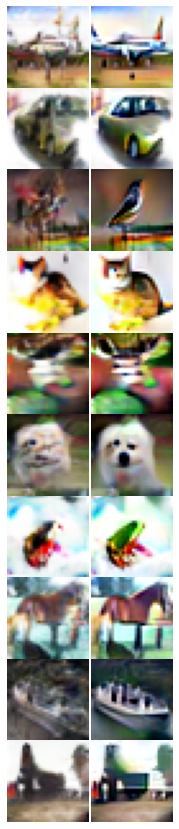

In [ ]:
# visualization

import matplotlib.pyplot as plt

# reproducibility
# torch.manual_seed(7)

X_g2 = []
for i in range(10):
    gen_imgs = netG.generate_images(num_images=10, device=device,c=i)
    X_g2.append(gen_imgs[0:1])
X_g2 = torch.cat(X_g2, dim=0)
print(X_g2.shape)

eps = 15

labels = torch.tensor([0,1,2,3,4,5,6,7,8,9]).cuda()
x_a = targeted_pgd_l2(model, X_g2, labels, num_iter=30, eps=eps, step_size= eps / 30)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

plt.figure(figsize=(3,15))
for i in range(10):
  plt.subplot(10, 2, 2*(i)+1)
  plt.imshow(((X_g2[i]+1) / 2).detach().cpu().permute(1,2,0))
  plt.axis('off')
for i in range(10):
  plt.subplot(10, 2, 2*(i+1))
  # plt.title(f'{classes[i]}', fontsize=25)
  plt.imshow(((x_a[i]+1) / 2).detach().cpu().permute(1,2,0))
  plt.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

$BIGRoC_{GT}$

In [ ]:
from tqdm.notebook import tqdm

netG.eval()
# Boost params
num_steps = 7
eps = 3
step_size = 1.5 * eps / num_steps
#
for _ in range(5):
  boosted_imgs = []
  imgs = []
  for i in tqdm(range(50000 // 50)):
    with torch.no_grad():
      gen_imgs, labels = netG.generate_images_with_labels(num_images=50, device=device, c = i % 10)
    imgs.append(gen_imgs)
    # _, labels = torch.max(model(gen_imgs), dim=1)
    gen_imgs_boosted = targeted_pgd_l2(model=model, X=gen_imgs.data, y=labels.long(), num_iter=num_steps, eps=eps,
                                        step_size=step_size)
    boosted_imgs.append(gen_imgs_boosted.detach().cpu())
  #  
  imgs = torch.cat(imgs, dim=0)
  boosted_imgs = torch.cat(boosted_imgs, dim=0)
  FID = get_FID(X_test, imgs, fid_model)
  print(f'vanilla FID : {FID}')
  print(f'vanilla TF IS {get_IS(imgs)}')
  FID = get_FID(X_test, boosted_imgs, fid_model)
  print(f'boosted FID : {FID}')
  print(f'boosted TF IS {get_IS(boosted_imgs)}')

  0%|          | 0/1000 [00:00<?, ?it/s]

vanilla FID : 11.1988793727391
vanilla TF IS (8.329641, 0.086031176)
boosted FID : 8.608653396297541
boosted TF IS (8.796138, 0.080078)


  0%|          | 0/1000 [00:00<?, ?it/s]

vanilla FID : 11.031216727414972
vanilla TF IS (8.337621, 0.07783859)
boosted FID : 8.495882092484976
boosted TF IS (8.745942, 0.09110009)


  0%|          | 0/1000 [00:00<?, ?it/s]

vanilla FID : 11.106822280286337
vanilla TF IS (8.31045, 0.09868682)
boosted FID : 8.52774729874011
boosted TF IS (8.775589, 0.13117495)


  0%|          | 0/1000 [00:00<?, ?it/s]

vanilla FID : 11.141212110576646
vanilla TF IS (8.338125, 0.08673227)
boosted FID : 8.582977743977835
boosted TF IS (8.748423, 0.115488395)


  0%|          | 0/1000 [00:00<?, ?it/s]

vanilla FID : 11.037716377751224
vanilla TF IS (8.343083, 0.0744875)
boosted FID : 8.47893876049136
boosted TF IS (8.811442, 0.07240505)
